This codebook will demonstrate working on the Prophet algorithm using the Adobe historical stock dataset. First, the necessary libraries need to be imported.

In [1]:
# import necessary libraries
import numpy as np #for powerful array and fast math operations
import pandas as pd #for creating and working on dataframes
import matplotlib.pyplot as plt #for creating plots and charts
import seaborn as sns #another visualization library for better and easier plots
import kagglehub #for interacting with kaggle to download datasets
import os #for interacting with the os to read csv
import prophet #importing the prophet library
from prophet.make_holidays import make_holidays_df #importing holidays for the algorithm

Now the dataset needs to be loaded. It will be loaded and handled with kagglehub and os libraries.

In [2]:
# Download latest version of the dataset
path = kagglehub.dataset_download("paultimothymooney/stock-market-data")

print("Path to dataset files:", path)

100%|██████████| 1.03G/1.03G [00:35<00:00, 31.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/paultimothymooney/stock-market-data/versions/74


In [3]:
# `path` points to the downloaded dataset directory
dataset_dir = path

# List files in the dataset directory to identify the data files
print("Files in dataset directory:", os.listdir(dataset_dir))

Files in dataset directory: ['stock_market_data']


Now the dataset will be read using the read.csv function and the first few columns along with data types will be observed.

In [4]:
# Load Adobe stock data
adbe_path = os.path.join(dataset_dir, "stock_market_data", "nasdaq", "csv", "ADBE.csv")
adbe_df = pd.read_csv(adbe_path)

# Inspect first rows
print(adbe_df.head())
print(adbe_df.info())

         Date       Low  Open    Volume      High     Close  Adjusted Close
0  13-08-1986  0.210938   0.0  18899200  0.218750  0.210938        0.198057
1  14-08-1986  0.222656   0.0   4160000  0.230469  0.222656        0.209060
2  15-08-1986  0.218750   0.0   4332800  0.222656  0.218750        0.205392
3  18-08-1986  0.210938   0.0   2828800  0.218750  0.210938        0.198057
4  19-08-1986  0.214844   0.0   2060800  0.218750  0.214844        0.201725
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9158 entries, 0 to 9157
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            9158 non-null   object 
 1   Low             9158 non-null   float64
 2   Open            9158 non-null   float64
 3   Volume          9158 non-null   int64  
 4   High            9158 non-null   float64
 5   Close           9158 non-null   float64
 6   Adjusted Close  9158 non-null   float64
dtypes: float64(5), int64(1), obj

The output from the last cell showed that the 'Date' column contains object datatype. But Prophet requires the the date to be datetime format. The following cell will convert the dates to datetime format.

In [5]:
# Turning dates into datetime format
adbe_df['Date'] = pd.to_datetime(adbe_df['Date'], dayfirst = True)

In [6]:
adbe_df.tail(n=20)

,Date,Low,Open,Volume,High,Close,Adjusted Close
9138,2022-11-14,334.429993,338.070007,3464500,345.109985,340.369995,340.369995
9139,2022-11-15,342.559998,348.410004,2948600,350.970001,345.959991,345.959991
9140,2022-11-16,336.720001,345.000000,2123200,345.019989,338.410004,338.410004
9141,2022-11-17,329.350006,331.739990,2740400,339.869995,337.829987,337.829987
9142,2022-11-18,329.140015,344.299988,3421700,344.700012,330.859985,330.859985
9143,2022-11-21,320.600006,329.529999,3219900,330.250000,321.489990,321.489990
9144,2022-11-22,320.200012,322.489990,2573800,331.540009,330.880005,330.880005
9145,2022-11-23,327.589996,329.929993,2240800,338.500000,335.779999,335.779999
9146,2022-11-25,332.010010,332.890015,1197800,335.510010,334.299988,334.299988
9147,2022-11-28,328.070007,335.829987,2314800,338.190002,328.970001,328.970001


Now the dataset needs to be checked for any missing dates. For this, I'll first find out the total range of date the data spans over. From this, I'll calculate the total calendar days. Then I'll subtract from it the available dates in my dataset, the holidays, and the weekends. This will give me the missing dates.

In [7]:
# Find the total number of dates available in the dataset
start_date = adbe_df['Date'].min()
end_date = adbe_df['Date'].max()

print(f"Date range: {start_date} to {end_date}")

Date range: 1986-08-13 00:00:00 to 2022-12-12 00:00:00


In [8]:
# Calculate the total number of calendar days in the timeline
full_timeline = pd.date_range(start=start_date, end=end_date, freq='D')
total_calendar_days = len(full_timeline)
# Calculate the number of days available in the dataset
available_data_days = len(adbe_df)
print(f"Total calendar days in the timeline: {total_calendar_days}")
print(f"Number of days with available data: {available_data_days}")

Total calendar days in the timeline: 13271
Number of days with available data: 9158


In [9]:
# Calculate the number of weekends in the timeline
number_of_weekends = sum(full_timeline.dayofweek >= 5)
print(f"Number of weekend days (Sat/Sun): {number_of_weekends}")

Number of weekend days (Sat/Sun): 3792


In [10]:
# Calculate the number of holidays for the period
year_list = range(start_date.year, end_date.year + 1)
holidays_df = make_holidays_df(year_list=year_list, country='US')
# Filter holidays to be within the timeline and not on a weekend
holidays_in_timeline = holidays_df[(holidays_df['ds'] >= start_date) & (holidays_df['ds'] <= end_date) & (holidays_df['ds'].dt.dayofweek < 5)]
number_of_holidays = len(holidays_in_timeline)
print(f"Number of public holiday weekdays: {number_of_holidays}")

Number of public holiday weekdays: 366


In [11]:
# find the days that are missing on the dataset
missing_days = total_calendar_days - available_data_days - number_of_weekends - number_of_holidays
print(f"Missing days in the dataset: {missing_days}")

Missing days in the dataset: -45


Here the negative number is because prophet's holiday library includes some holidays on which stock market stays open. Since the number is only 45 in the span of 36 years, this is minimal and therefore it is ignoreable.

Now I'll prepare my data for Prophet algorithm. Since 2020 contains the COVID pandemic, an anomaly that caused a lot of volatility, I'll train and test my model with data up till 2020.

In [12]:
# Filter a range for model training
start_date = '1986-08-13'
end_date = '2019-12-31'

# Filter ADBE stock
adbe_train = adbe_df[(adbe_df['Date'] >= start_date) & (adbe_df['Date'] <= end_date)].copy()

adbe_train = adbe_train.set_index('Date')

In [13]:
# inspect the dataset
adbe_train.head(n=20)

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,
1986-08-13,0.210938,0.0,18899200,0.218750,0.210938,0.198057
1986-08-14,0.222656,0.0,4160000,0.230469,0.222656,0.209060
1986-08-15,0.218750,0.0,4332800,0.222656,0.218750,0.205392
1986-08-18,0.210938,0.0,2828800,0.218750,0.210938,0.198057
1986-08-19,0.214844,0.0,2060800,0.218750,0.214844,0.201725
1986-08-20,0.214844,0.0,684800,0.226563,0.214844,0.201725
1986-08-21,0.222656,0.0,883200,0.234375,0.222656,0.209060
1986-08-22,0.222656,0.0,1734400,0.230469,0.222656,0.209060
1986-08-25,0.214844,0.0,627200,0.222656,0.214844,0.201725


Now I'll check for any duplicates dates, because each date should only have one value for each of the columns and therefore only one row.

In [14]:
# check for duplictaes
duplicate = adbe_train.reset_index().duplicated(subset=['Date'])
adbe_train[duplicate.values]

,Low,Open,Volume,High,Close,Adjusted Close
Date,,,,,,


Since there are no duplicates found, I'll go forward to check the relationship between the variables. The 'pairplot' function shows the realationship between each variable in separate graphs, making it easy to inspect the realtion and find an anomaly.

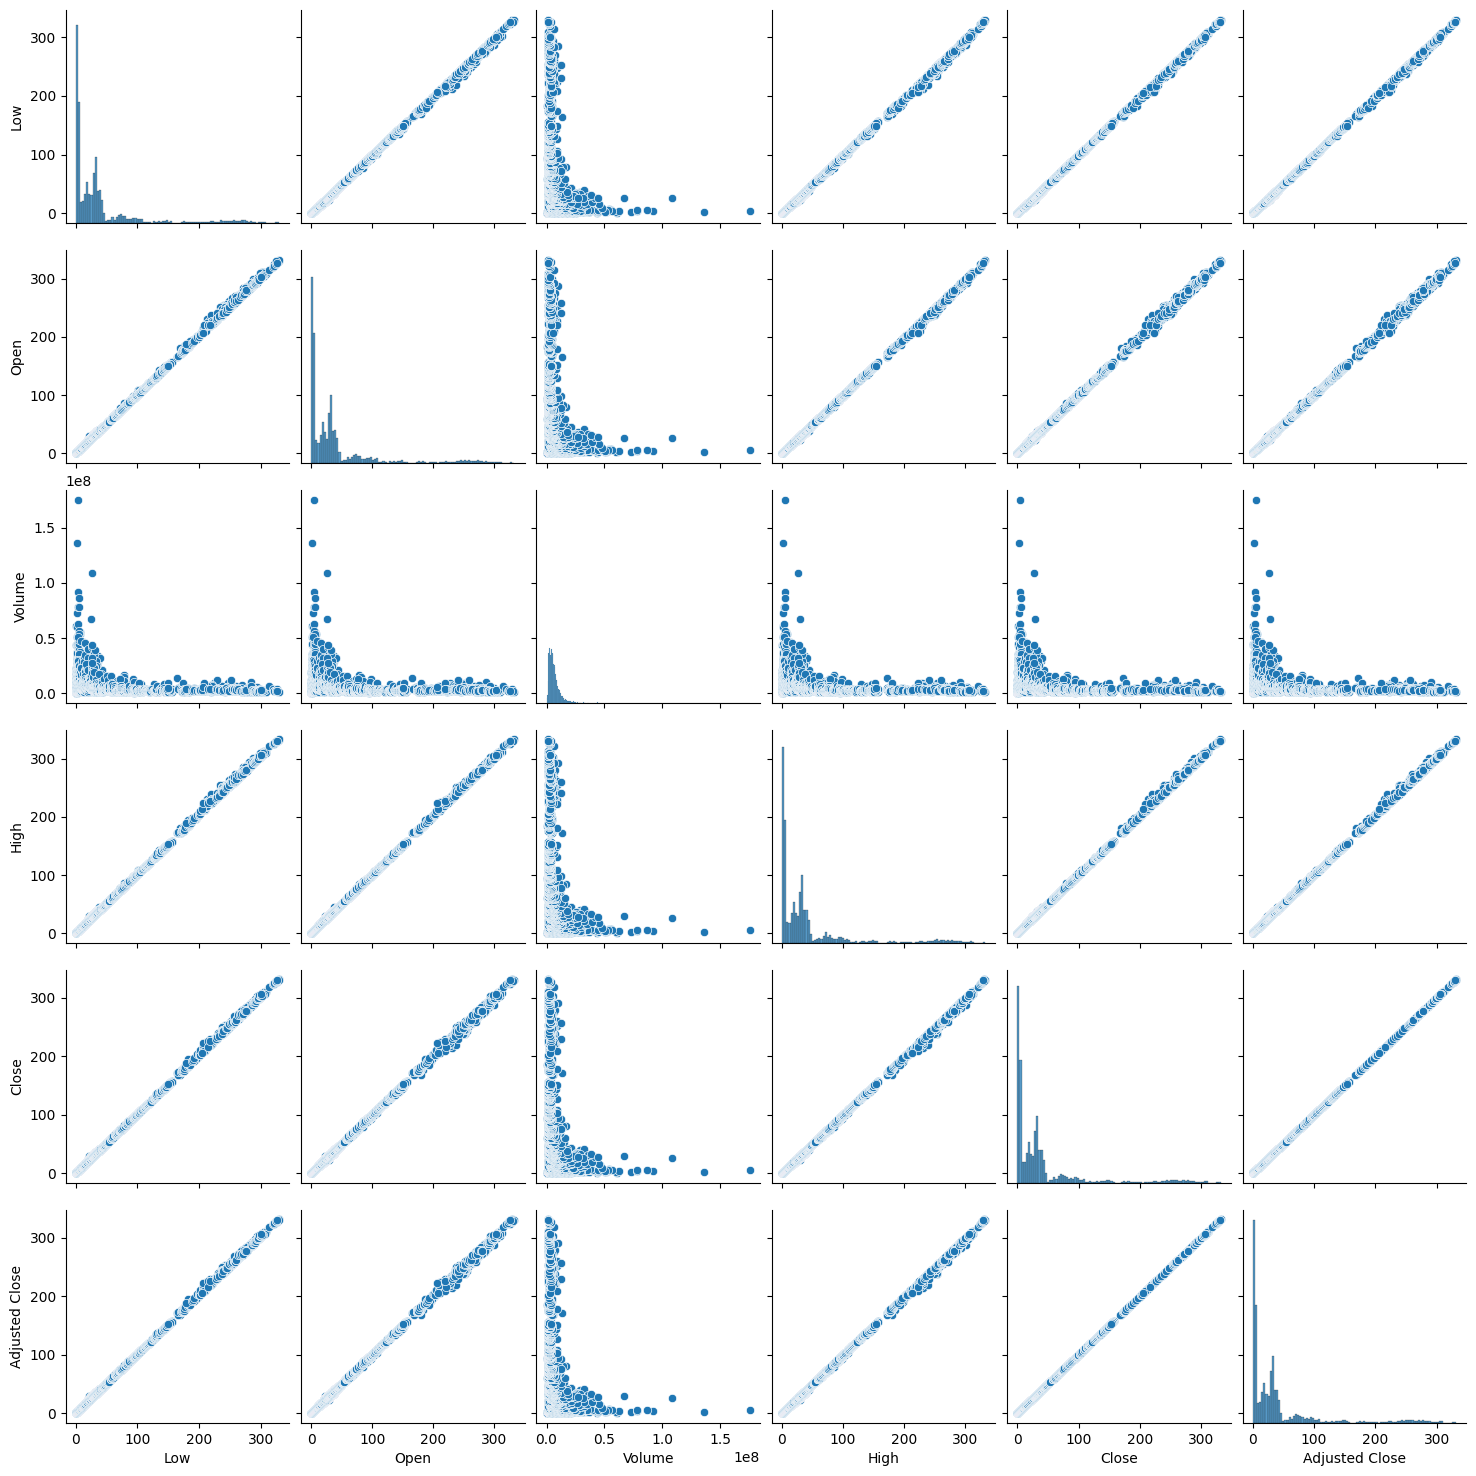

In [15]:
sns.pairplot(adbe_train)
plt.show()

Now I'll create a new dataframe with only the necessary columns. Prophet requires the 'Dates' column to be named 'ds', and the column we'll predict (here 'Adjusted Close') to be named 'y'. Tlog transform the variables, because it stabilizes the variables and handles non-linear growth, that are usually seen in stock data.

In [16]:
train_df = adbe_train[['Adjusted Close']].reset_index()
train_df.rename(columns={'Date': 'ds', 'Adjusted Close': 'y'}, inplace=True)
train_df.head(n=20)

,ds,y
0,1986-08-13,0.198057
1,1986-08-14,0.209060
2,1986-08-15,0.205392
3,1986-08-18,0.198057
4,1986-08-19,0.201725
5,1986-08-20,0.201725
6,1986-08-21,0.209060
7,1986-08-22,0.209060
8,1986-08-25,0.201725
9,1986-08-26,0.201725


In [17]:
# log transformation
import numpy as np
train_df_log = train_df.copy()
train_df_log['y'] = np.log1p(train_df_log['y'])
train_df_log.head(n=10)

,ds,y
0,1986-08-13,0.180701
1,1986-08-14,0.189843
2,1986-08-15,0.186805
3,1986-08-18,0.180701
4,1986-08-19,0.183758
5,1986-08-20,0.183758
6,1986-08-21,0.189843
7,1986-08-22,0.189843
8,1986-08-25,0.183758
9,1986-08-26,0.183758


I'll train 2 models. At first will be using the built in methods without any added regressors. Then I'll add some regressors to see if that helps the model's predictions.

I'll use the same train size, horizon, and storage for metrices for comparability. i'll train on 90% of data using a 60 day horizon for forecasting.

In [18]:
# Parameters for model traininng
initial_train_size = int(0.9 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon

# Storage for metrics
metrics_1 = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

Now I'll import holidays from the Prophet's built in methods. Adding holidays is importatnt because holidays introduce sudden spikes in stock proces.

In [19]:
from prophet import Prophet
from prophet.make_holidays import make_holidays_df

# Make holidays DataFrame for US
holidays = make_holidays_df(year_list=range(1986, 2022), country='US')

Now I'll train the first model. It'll be a basic model without regressors using the Prophet's built in cross validation function for this.

In [20]:
# built in cross validation model (without any added regressors)
import prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import logging

# Suppress warnings using logging
logging.getLogger('prophet').setLevel(logging.ERROR)

# Initialize and tune Prophet with built-in components
model_1 = Prophet(
    growth='linear', #assuming data grows and shrinks at steady rate without caps
    daily_seasonality=False, #since there's no hourly data
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive', #because the data is log-transformed
    changepoint_prior_scale=0.5, #higher value for more flexibility and trend changes
    interval_width=0.95, #95% confidence interval
    uncertainty_samples=1000, #more samples for more stable interval
    seasonality_prior_scale=0.1, #small to smooth out the seasonality to reduce overfitting
    holidays=holidays
)

# Add quarterly seasonality to reflect quaterly patterns
model_1.add_seasonality(name='quarterly', period=91.3, fourier_order=5) #stock data usually show quarterly seasonality

print(f"\nTraining Prophet on {len(train_df_log)} data points")
model_1.fit(train_df_log)

# Cross-validation with parameter tuning
print(f"\nRunning cross-validation:")
print(f"  Initial training size: {initial_train_size} days (90% of data)")
print(f"  Horizon: {horizon} days")
print(f"  Number of folds: {n_iterations}")

df_cv = cross_validation(
    model_1,
    initial=f'{initial_train_size} days',
    horizon=f'{horizon} days',
    period=f'{horizon} days',
    parallel='processes'
)

print(f"  Total predictions made: {len(df_cv)}")

# Reverse log transformation for actual scale metrics
df_cv['y_actual'] = np.expm1(df_cv['y'])
df_cv['yhat_actual'] = np.expm1(df_cv['yhat'])
df_cv['yhat_lower_actual'] = np.expm1(df_cv['yhat_lower'])
df_cv['yhat_upper_actual'] = np.expm1(df_cv['yhat_upper'])

# Store predictions dataframe
predictions_cv_no_regressors = df_cv.copy()

# Calculate metrics in original scale
mae = mean_absolute_error(df_cv['y_actual'], df_cv['yhat_actual'])
rmse = np.sqrt(mean_squared_error(df_cv['y_actual'], df_cv['yhat_actual']))
mape = np.mean(np.abs((df_cv['y_actual'] - df_cv['yhat_actual']) / (df_cv['y_actual'] + 1e-8))) * 100
r2 = r2_score(df_cv['y_actual'], df_cv['yhat_actual'])

# Coverage analysis
in_interval = np.sum((df_cv['y_actual'] >= df_cv['yhat_lower_actual']) &
                     (df_cv['y_actual'] <= df_cv['yhat_upper_actual']))
coverage_pct = (in_interval / len(df_cv)) * 100
avg_width_pct = np.mean((df_cv['yhat_upper_actual'] - df_cv['yhat_lower_actual']) /
                        df_cv['y_actual']) * 100

print("Model results with built_in components:")

print(f"\nMAE      = {mae:.3f}")
print(f"RMSE     = {rmse:.3f}")
print(f"MAPE     = {mape:.3f}")
print(f"R²       = {r2:.4f}")

print(f"\nCOVERAGE = {coverage_pct:.1f}%")
print(f"AVG WIDTH = {avg_width_pct:.1f}%")


Training Prophet on 8415 data points


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/bs72pkai.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_8glit8f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22468', 'data', 'file=/tmp/tmp6lx9i1kp/bs72pkai.json', 'init=/tmp/tmp6lx9i1kp/_8glit8f.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model21fh1myp/prophet_model-20251025074233.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:42:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



Running cross-validation:
  Initial training size: 7573 days (90% of data)
  Horizon: 60 days
  Number of folds: 14


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/g5x97ai7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/8g1o9wcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/qizz6n0c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57414', 'data', 'file=/tmp/tmp6lx9i1kp/g5x97ai7.json', 'init=/tmp/tmp6lx9i1kp/qizz6n0c.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model1ro2lyqh/prophet_model-20251025074252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:42:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/murmym1g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95492', 'data

  Total predictions made: 3185
Model results with built_in components:

MAE      = 11.482
RMSE     = 16.414
MAPE     = 17.615
R²       = 0.9587

COVERAGE = 78.8%
AVG WIDTH = 53.0%


Although this model resulted in decent r2 value and coverage, the MAE, RMSE, and MAPE values are not ideal for a stock forecasting model.

I'll use the following cell to save the predictions now, so I don't have to run it everytime my runtime disconnects to get the results.

In [21]:
# Save the predictions after running model 1
import pickle
predictions_cv_no_regressors.to_csv('predictions_cv_no_regressors.csv', index=False)
print("Saved predictions_cv_no_regressors")

Saved predictions_cv_no_regressors


In [24]:
# load the predictions to chcek
predictions_cv_no_regressors = pd.read_csv('predictions_cv_no_regressors.csv', parse_dates=['ds'])
predictions_cv_no_regressors.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,y_actual,yhat_actual,yhat_lower_actual,yhat_upper_actual
0,2007-05-09,3.909637,3.662112,4.134962,3.743841,2007-05-08,41.259998,48.880845,37.943497,61.487242
1,2007-05-10,3.913326,3.685855,4.152995,3.729541,2007-05-08,40.660000,49.065203,38.879196,62.624249
2,2007-05-11,3.914520,3.685965,4.154860,3.754199,2007-05-08,41.700001,49.124985,38.883574,62.743018
3,2007-05-14,3.919799,3.679759,4.163588,3.756772,2007-05-08,41.810001,49.390316,38.636846,63.301816
4,2007-05-15,3.922921,3.686999,4.163032,3.746441,2007-05-08,41.369999,49.547865,38.924851,63.266100


Now I'll visualize all the components (weekly, yearly, and quately seasonality,holiday, and trend) using Prophet's built in plot_components. This gives us a clear idea about the patterns.

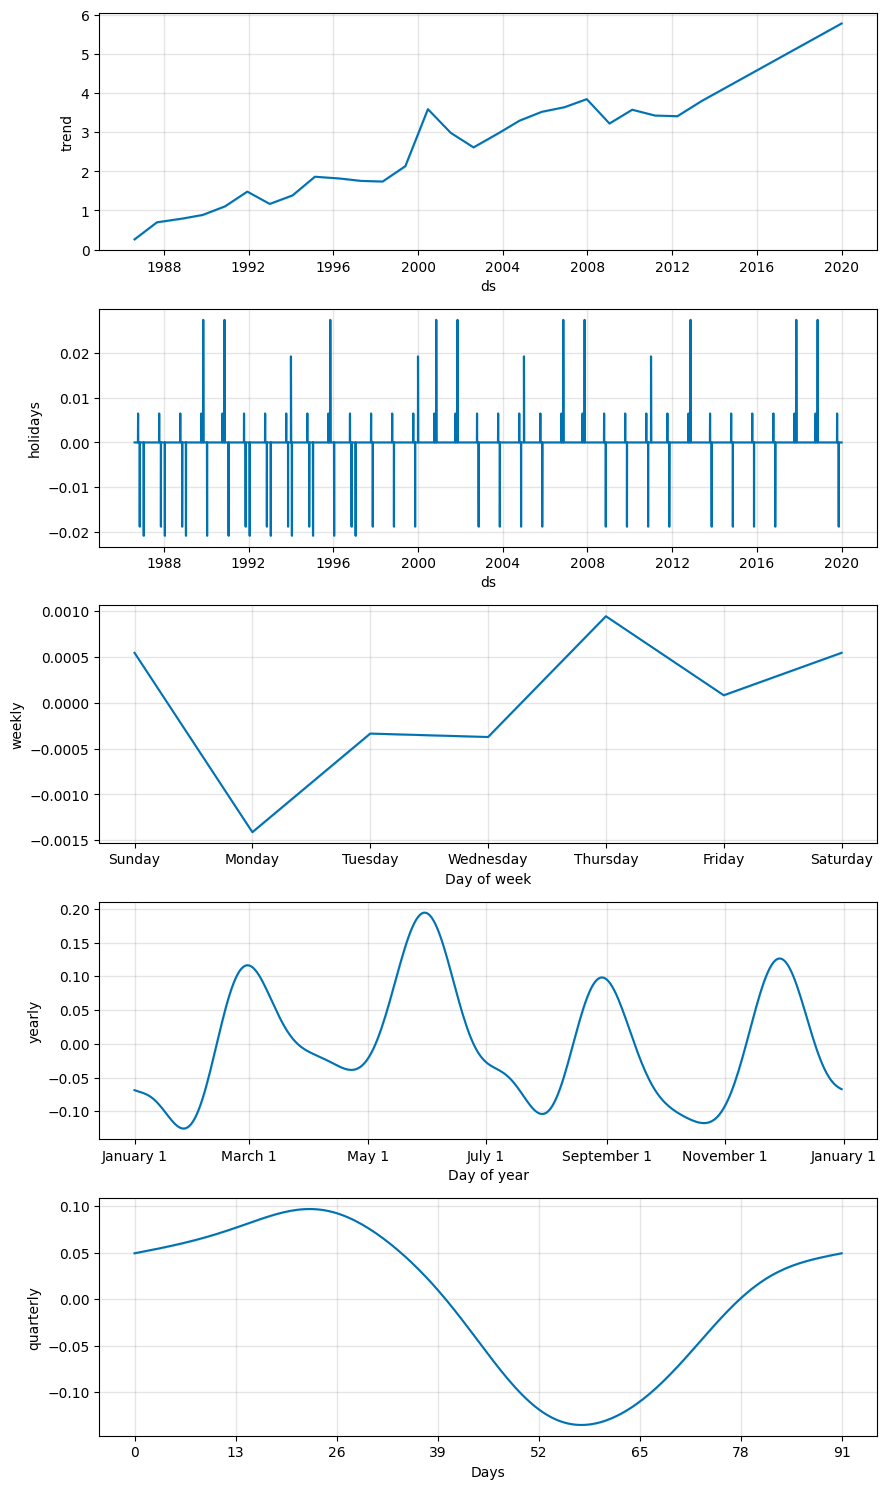

In [25]:
# Visualize all the components of the dataset
forecast_model_1 = model_1.predict(train_df_log)

figure_1 = model_1.plot_components(forecast_model_1)
plt.show()

Now I'll visualize the MAPE metric. It shows 4% instead of 16% because it's calculated in the log transformed space.

/usr/local/lib/python3.12/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.12/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


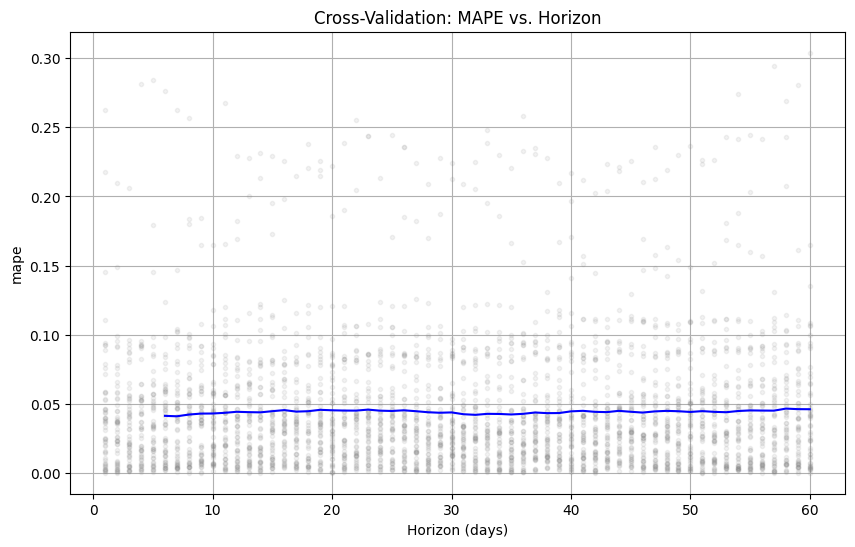

In [26]:
from prophet.plot import plot_cross_validation_metric
# You can change 'mape' to 'rmse', 'mae', or 'mdape'.
fiure_2 = plot_cross_validation_metric(df_cv, metric='mape')
plt.title("Cross-Validation: MAPE vs. Horizon")
plt.show()

Now I'll train the model creating and adding some regressors to see if they improve the model's prediction. The regressors are not exogenous in nature, and are derived from this dataset. I'll use autoregression to predict future regressors and avoid any data leakage. The train size and horizon will be the same as before.

In [27]:
# Parameters for iterative traininng
initial_train_size = int(0.9 * len(train_df_log))
horizon = 60
n_iterations = (len(train_df_log) - initial_train_size) // horizon

In [28]:
# Storage for metrics
metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

The following model includes the following regressors: lag 1, 2, 3, and 7 (previous days' closing prices), simple moving average 7, and 30 (using rolling window means), 5 and 10 days' momentum, volatility 7 and 30 (using rolling window standard deviations), and trend strength (deviation from sma 30).

In [29]:
# Walk forward validation and performance metrics with autoregression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Main Walk-Forward Loop
train_end = initial_train_size
all_fold_forecasts = []
coverage_metrics = {'in_coverage': [], 'coverage_width': []}

# Store all predictions for later visualization
all_predictions_list = []

for i in range(n_iterations):
    # Define current training and testing windows
    current_train = train_df_log.iloc[:train_end].copy()
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    print(f"Iteration {i+1}/{n_iterations}: Training on {len(current_train)} data points, testing on {len(test_df)}.")

    # Recalculate features on the loop to avoid leakage
    current_train_clean = current_train[['ds', 'y']].copy()

    # Include basic lags
    current_train_clean['lag1'] = current_train_clean['y'].shift(1)
    current_train_clean['lag2'] = current_train_clean['y'].shift(2)
    current_train_clean['lag3'] = current_train_clean['y'].shift(3)
    current_train_clean['lag7'] = current_train_clean['y'].shift(7)

    # Include moving averages
    current_train_clean['sma_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).mean()
    current_train_clean['sma_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).mean()

    # Include momentum indicators
    current_train_clean['momentum_5'] = current_train_clean['y'] - current_train_clean['y'].shift(5)
    current_train_clean['momentum_10'] = current_train_clean['y'] - current_train_clean['y'].shift(10)

    # Include volatility (rolling std)
    current_train_clean['volatility_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).std()
    current_train_clean['volatility_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).std()

    # Include trend strength (price relative to moving average)
    current_train_clean['trend_strength'] = current_train_clean['y'] - current_train_clean['sma_30']

    # Drop rows with NaN
    current_train_clean = current_train_clean.dropna()

    if len(current_train_clean) < 50:
        print("  Insufficient training data after feature engineering. Skipping.")
        continue

    # Initialize and Fit Model with Reduced Seasonality
    model_2 = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=0.05,  # Lower value is less flexible (prevents overfitting)
        interval_width=0.95,
        uncertainty_samples=1000,
        seasonality_prior_scale=0.1,
        holidays=holidays
    )

    # Add regressors to the model
    regressors = ['lag1', 'lag2', 'lag3', 'lag7', 'sma_7', 'sma_30', 'momentum_5', 'momentum_10', 'volatility_7', 'volatility_30', 'trend_strength']

    for reg in regressors:
        model_2.add_regressor(reg)
    model_2.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

    model_2.fit(current_train_clean)

    # Forecasting with Actual Values (not recursive)
    history_y = current_train_clean['y'].values.tolist()
    fold_predictions = []
    actual_dates = test_df['ds'].values

    for step in range(len(test_df)):
        # Create future dataframe
        future_step_df = pd.DataFrame({'ds': [actual_dates[step]]})

        # Calculate regressors from history
        history_array = np.array(history_y)

        future_step_df['lag1'] = history_array[-1]
        future_step_df['lag2'] = history_array[-2]
        future_step_df['lag3'] = history_array[-3]
        future_step_df['lag7'] = history_array[-7] if len(history_array) >= 7 else history_array[0]

        future_step_df['sma_7'] = history_array[-7:].mean() if len(history_array) >= 7 else history_array.mean()
        future_step_df['sma_30'] = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()

        future_step_df['momentum_5'] = history_array[-1] - (history_array[-6] if len(history_array) >= 6 else history_array[0])
        future_step_df['momentum_10'] = history_array[-1] - (history_array[-11] if len(history_array) >= 11 else history_array[0])

        future_step_df['volatility_7'] = np.std(history_array[-7:]) if len(history_array) >= 7 else 0
        future_step_df['volatility_30'] = np.std(history_array[-30:]) if len(history_array) >= 30 else 0

        sma_30_current = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()
        future_step_df['trend_strength'] = history_array[-1] - sma_30_current

        # Make prediction with intervals
        forecast_step = model_2.predict(future_step_df)
        fold_predictions.append(forecast_step)

        # Use actual value for next iteration
        actual_log_value = test_df.iloc[step]['y']
        history_y.append(actual_log_value)

    # Calculate Metrics with Coverage
    fold_forecast_df = pd.concat(fold_predictions).reset_index(drop=True)
    all_fold_forecasts.append(fold_forecast_df)

    # Reverse log transformation
    y_true_original_2 = np.expm1(test_df['y'].values)
    y_pred_original_2 = np.expm1(fold_forecast_df['yhat'].values)
    y_lower_original_2 = np.expm1(fold_forecast_df['yhat_lower'].values)
    y_upper_original_2 = np.expm1(fold_forecast_df['yhat_upper'].values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_original_2[j],
            'y_pred_log': fold_forecast_df.iloc[j]['yhat'],
            'y_pred': y_pred_original_2[j],
            'y_lower_log': fold_forecast_df.iloc[j]['yhat_lower'],
            'y_lower': y_lower_original_2[j],
            'y_upper_log': fold_forecast_df.iloc[j]['yhat_upper'],
            'y_upper': y_upper_original_2[j],
            'fold': i + 1
        })

    # Standard metrics
    mae = mean_absolute_error(y_true_original_2, y_pred_original_2)
    rmse = np.sqrt(mean_squared_error(y_true_original_2, y_pred_original_2))
    mape = np.mean(np.abs((y_true_original_2 - y_pred_original_2) / (y_true_original_2 + 1e-8))) * 100
    r2 = r2_score(y_true_original_2, y_pred_original_2)

    # Coverage metrics
    in_interval = np.sum((y_true_original_2 >= y_lower_original_2) & (y_true_original_2 <= y_upper_original_2))
    coverage = (in_interval / len(y_true_original_2)) * 100
    avg_interval_width = np.mean(y_upper_original_2 - y_lower_original_2)
    avg_interval_width_pct = np.mean((y_upper_original_2 - y_lower_original_2) / y_true_original_2) * 100


    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    coverage_metrics['in_coverage'].append(coverage)
    coverage_metrics['coverage_width'].append(avg_interval_width_pct)

    # Move the training window (candlestick method)
    train_end += horizon

    print(f"    MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
    print(f"    Coverage: {coverage:.1f}% | Avg Width: {avg_interval_width_pct:.1f}%")

# Create comprehensive predictions dataframe
predictions_df_with_regressors_nr = pd.DataFrame(all_predictions_list)

# Aggregate and Display Final Metrics
print("AGGREGATED METRICS (Walk-Forward Validation with added regressors)")

agg_metrics = {k: np.mean(v) for k, v in metrics.items()}
for k, v in agg_metrics.items():
    std_val = np.std(metrics[k])
    print(f"{k.upper():8} = {v:7.3f} (±{std_val:.3f})")

print(f"\nCOVERAGE  = {np.mean(coverage_metrics['in_coverage']):7.1f}% (±{np.std(coverage_metrics['in_coverage']):.1f}%)")
print(f"AVG WIDTH = {np.mean(coverage_metrics['coverage_width']):7.1f}% (±{np.std(coverage_metrics['coverage_width']):.1f}%)")


Iteration 1/14: Training on 7573 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/9pw0wah6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/rlyrazaq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26911', 'data', 'file=/tmp/tmp6lx9i1kp/9pw0wah6.json', 'init=/tmp/tmp6lx9i1kp/rlyrazaq.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model_w8ize8x/prophet_model-20251025080106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:01:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:01:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/2m1qrlq4.json


    MAE: 0.91 | RMSE: 1.43 | MAPE: 0.86% | R²: 0.817
    Coverage: 21.7% | Avg Width: 0.4%
Iteration 2/14: Training on 7633 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ii4s4g3_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47382', 'data', 'file=/tmp/tmp6lx9i1kp/2m1qrlq4.json', 'init=/tmp/tmp6lx9i1kp/ii4s4g3_.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model10rj9bnm/prophet_model-20251025080204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:02:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/sp01g8u6.json


    MAE: 0.83 | RMSE: 1.09 | MAPE: 0.77% | R²: 0.955
    Coverage: 28.3% | Avg Width: 0.6%
Iteration 3/14: Training on 7693 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/tou4j68j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88135', 'data', 'file=/tmp/tmp6lx9i1kp/sp01g8u6.json', 'init=/tmp/tmp6lx9i1kp/tou4j68j.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelocg7ioed/prophet_model-20251025080304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:03:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:03:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/d_af_een.json


    MAE: 0.59 | RMSE: 0.88 | MAPE: 0.46% | R²: 0.977
    Coverage: 33.3% | Avg Width: 0.4%
Iteration 4/14: Training on 7753 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/6dtebrhw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51883', 'data', 'file=/tmp/tmp6lx9i1kp/d_af_een.json', 'init=/tmp/tmp6lx9i1kp/6dtebrhw.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelg4on82q3/prophet_model-20251025080359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:03:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:04:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/7q3vntuq.json


    MAE: 1.23 | RMSE: 1.61 | MAPE: 0.86% | R²: 0.839
    Coverage: 15.0% | Avg Width: 0.5%
Iteration 5/14: Training on 7813 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ez7psuxw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46335', 'data', 'file=/tmp/tmp6lx9i1kp/7q3vntuq.json', 'init=/tmp/tmp6lx9i1kp/ez7psuxw.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelgjcqxvk0/prophet_model-20251025080454.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:04:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:05:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/1a787uzz.json


    MAE: 1.76 | RMSE: 3.12 | MAPE: 1.11% | R²: 0.894
    Coverage: 20.0% | Avg Width: 0.6%
Iteration 6/14: Training on 7873 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/7ohof70m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41294', 'data', 'file=/tmp/tmp6lx9i1kp/1a787uzz.json', 'init=/tmp/tmp6lx9i1kp/7ohof70m.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelygil3afi/prophet_model-20251025080551.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:05:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:06:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/4frduwlg.json


    MAE: 1.94 | RMSE: 2.81 | MAPE: 1.06% | R²: 0.895
    Coverage: 30.0% | Avg Width: 0.6%
Iteration 7/14: Training on 7933 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/na9409as.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89178', 'data', 'file=/tmp/tmp6lx9i1kp/4frduwlg.json', 'init=/tmp/tmp6lx9i1kp/na9409as.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelelg5mn_r/prophet_model-20251025080648.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:06:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:07:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/m8iiqt7h.json


    MAE: 3.47 | RMSE: 4.61 | MAPE: 1.62% | R²: 0.852
    Coverage: 15.0% | Avg Width: 0.5%
Iteration 8/14: Training on 7993 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/sxco3h26.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96217', 'data', 'file=/tmp/tmp6lx9i1kp/m8iiqt7h.json', 'init=/tmp/tmp6lx9i1kp/sxco3h26.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model_19hyqqf/prophet_model-20251025080746.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:07:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:08:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.52 | RMSE: 3.04 | MAPE: 1.03% | R²: 0.900
    Coverage: 16.7% | Avg Width: 0.6%
Iteration 9/14: Training on 8053 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/i7qmccj4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ux9v2t3j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42893', 'data', 'file=/tmp/tmp6lx9i1kp/i7qmccj4.json', 'init=/tmp/tmp6lx9i1kp/ux9v2t3j.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model_24xgyrh/prophet_model-20251025080850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:08:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:09:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.88 | RMSE: 5.68 | MAPE: 1.51% | R²: 0.614
    Coverage: 18.3% | Avg Width: 0.6%
Iteration 10/14: Training on 8113 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/gdgyuvtw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/zcb9rrxm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28235', 'data', 'file=/tmp/tmp6lx9i1kp/gdgyuvtw.json', 'init=/tmp/tmp6lx9i1kp/zcb9rrxm.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelvmqs_gyk/prophet_model-20251025080953.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:09:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:10:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 5.54 | RMSE: 7.40 | MAPE: 2.36% | R²: 0.598
    Coverage: 13.3% | Avg Width: 0.5%
Iteration 11/14: Training on 8173 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/eqpnfrby.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/f90dgqg3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41910', 'data', 'file=/tmp/tmp6lx9i1kp/eqpnfrby.json', 'init=/tmp/tmp6lx9i1kp/f90dgqg3.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model33bamajo/prophet_model-20251025081057.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:10:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:11:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_i_huu4v.json


    MAE: 2.25 | RMSE: 3.04 | MAPE: 0.87% | R²: 0.874
    Coverage: 18.3% | Avg Width: 0.3%
Iteration 12/14: Training on 8233 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/708t6mc8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59881', 'data', 'file=/tmp/tmp6lx9i1kp/_i_huu4v.json', 'init=/tmp/tmp6lx9i1kp/708t6mc8.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model35y7s6le/prophet_model-20251025081201.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:12:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:12:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.75 | RMSE: 4.96 | MAPE: 1.34% | R²: 0.789
    Coverage: 11.7% | Avg Width: 0.4%
Iteration 13/14: Training on 8293 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/g1sq3dr_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/bngdkuxn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96090', 'data', 'file=/tmp/tmp6lx9i1kp/g1sq3dr_.json', 'init=/tmp/tmp6lx9i1kp/bngdkuxn.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model4a4eziw_/prophet_model-20251025081304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:13:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:13:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.54 | RMSE: 4.34 | MAPE: 1.23% | R²: 0.871
    Coverage: 18.3% | Avg Width: 0.7%
Iteration 14/14: Training on 8353 data points, testing on 60.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/tnsst6ge.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/7o228jsi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48214', 'data', 'file=/tmp/tmp6lx9i1kp/tnsst6ge.json', 'init=/tmp/tmp6lx9i1kp/7o228jsi.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model_t06lzpb/prophet_model-20251025081408.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:14:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:14:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.61 | RMSE: 3.76 | MAPE: 0.90% | R²: 0.964
    Coverage: 28.3% | Avg Width: 0.4%
AGGREGATED METRICS (Walk-Forward Validation with added regressors)
MAE      =   2.486 (±1.369)
RMSE     =   3.411 (±1.803)
MAPE     =   1.142 (±0.447)
R2       =   0.846 (±0.111)

COVERAGE  =    20.6% (±6.5%)
AVG WIDTH =     0.5% (±0.1%)


Although this model produces decent results, this is not truly recursive in nature. Rather after each predction, it uses the original values of regressors, assuming each day the values up to the previous day will be fed to the model.

Now similar to the model before, I'll store and check the predictions of this model.

In [30]:
# Saving after running model with regressors
import pickle
predictions_df_with_regressors_nr.to_csv('predictions_with_regressors_nr.csv', index=False)
with open('metrics_with_reg.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("Saved predictions_df_with_regressors_nr")

Saved predictions_df_with_regressors_nr


In [31]:
predictions_df_with_regressors_nr = pd.read_csv('predictions_with_regressors_nr.csv', parse_dates=['ds'])
predictions_df_with_regressors_nr.head()

,ds,y_actual_log,y_actual,y_pred_log,y_pred,y_lower_log,y_lower,y_upper_log,y_upper,fold
0,2016-08-26,4.635311,102.059998,4.631750,101.693590,4.629467,101.459413,4.633888,101.913427,1
1,2016-08-29,4.637637,102.300003,4.635374,102.066446,4.633314,101.854362,4.637353,102.270664,1
2,2016-08-30,4.634729,102.000000,4.637707,102.307208,4.635762,102.106430,4.639753,102.518771,1
3,2016-08-31,4.637734,102.309998,4.634814,102.008774,4.632746,101.795945,4.636846,102.218271,1
4,2016-09-01,4.643429,102.900002,4.637812,102.318069,4.635415,102.070665,4.639868,102.530639,1


Now I'll train a true recursive model. Since the errors can compound on such models, I'll use a shorter horizon of 14 days and a higher changepoint prior scale (0.5).

In [32]:
# Parameters for iterative traininng
initial_train_size = int(0.9 * len(train_df_log))
horizon = 14
n_iterations = (len(train_df_log) - initial_train_size) // horizon
# Storage for metrics
metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

In [33]:
# Walk forward validation and performance metrics with autoregression (True Recursive)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Main Walk-Forward Loop
train_end = initial_train_size
all_fold_forecasts = []
coverage_metrics = {'in_coverage': [], 'coverage_width': []}

# Store all predictions for later visualization
all_predictions_list = []

for i in range(n_iterations):
    # Define current training and testing windows
    current_train = train_df_log.iloc[:train_end].copy()
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    print(f"Iteration {i+1}/{n_iterations}: Training on {len(current_train)} data points, testing on {len(test_df)}.")

    # Recalculate features on the loop to avoid leakage
    current_train_clean = current_train[['ds', 'y']].copy()

    # Include basic lags
    current_train_clean['lag1'] = current_train_clean['y'].shift(1)
    current_train_clean['lag2'] = current_train_clean['y'].shift(2)
    current_train_clean['lag3'] = current_train_clean['y'].shift(3)
    current_train_clean['lag7'] = current_train_clean['y'].shift(7)

    # Include moving averages
    current_train_clean['sma_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).mean()
    current_train_clean['sma_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).mean()

    # Include momentum indicators
    current_train_clean['momentum_5'] = current_train_clean['y'] - current_train_clean['y'].shift(5)
    current_train_clean['momentum_10'] = current_train_clean['y'] - current_train_clean['y'].shift(10)

    # Include volatility (rolling std)
    current_train_clean['volatility_7'] = current_train_clean['y'].rolling(window=7, min_periods=1).std()
    current_train_clean['volatility_30'] = current_train_clean['y'].rolling(window=30, min_periods=1).std()

    # Include trend strength (price relative to moving average)
    current_train_clean['trend_strength'] = current_train_clean['y'] - current_train_clean['sma_30']

    # Drop rows with NaN
    current_train_clean = current_train_clean.dropna()

    if len(current_train_clean) < 50:
        print("  Insufficient training data after feature engineering. Skipping.")
        continue

    # Initialize and Fit Model with Reduced Seasonality
    model_2 = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        seasonality_mode='additive',
        changepoint_prior_scale=0.5,  # Lower value is less flexible (prevents overfitting)
        interval_width=0.95,
        uncertainty_samples=1000,
        seasonality_prior_scale=0.1,
        holidays=holidays
    )

    # Add regressors to the model
    regressors = ['lag1', 'lag2', 'lag3', 'lag7', 'sma_7', 'sma_30', 'momentum_5', 'momentum_10', 'volatility_7', 'volatility_30', 'trend_strength']

    for reg in regressors:
        model_2.add_regressor(reg)
    model_2.add_seasonality(name='quarterly', period=91.3, fourier_order=5)

    model_2.fit(current_train_clean)

    # TRUE RECURSIVE Forecasting (using predicted values)
    history_y = current_train_clean['y'].values.tolist()
    fold_predictions = []
    actual_dates = test_df['ds'].values

    for step in range(len(test_df)):
        # Create future dataframe
        future_step_df = pd.DataFrame({'ds': [actual_dates[step]]})

        # Calculate regressors from history
        history_array = np.array(history_y)

        future_step_df['lag1'] = history_array[-1]
        future_step_df['lag2'] = history_array[-2]
        future_step_df['lag3'] = history_array[-3]
        future_step_df['lag7'] = history_array[-7] if len(history_array) >= 7 else history_array[0]

        future_step_df['sma_7'] = history_array[-7:].mean() if len(history_array) >= 7 else history_array.mean()
        future_step_df['sma_30'] = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()

        future_step_df['momentum_5'] = history_array[-1] - (history_array[-6] if len(history_array) >= 6 else history_array[0])
        future_step_df['momentum_10'] = history_array[-1] - (history_array[-11] if len(history_array) >= 11 else history_array[0])

        future_step_df['volatility_7'] = np.std(history_array[-7:]) if len(history_array) >= 7 else 0
        future_step_df['volatility_30'] = np.std(history_array[-30:]) if len(history_array) >= 30 else 0

        sma_30_current = history_array[-30:].mean() if len(history_array) >= 30 else history_array.mean()
        future_step_df['trend_strength'] = history_array[-1] - sma_30_current

        # Make prediction with intervals
        forecast_step = model_2.predict(future_step_df)
        fold_predictions.append(forecast_step)

        # TRUE RECURSIVE: Use PREDICTED value for next iteration
        predicted_log_value = forecast_step['yhat'].values[0]
        history_y.append(predicted_log_value)

    # Calculate Metrics with Coverage
    fold_forecast_df = pd.concat(fold_predictions).reset_index(drop=True)
    all_fold_forecasts.append(fold_forecast_df)

    # Reverse log transformation
    y_true_original_2 = np.expm1(test_df['y'].values)
    y_pred_original_2 = np.expm1(fold_forecast_df['yhat'].values)
    y_lower_original_2 = np.expm1(fold_forecast_df['yhat_lower'].values)
    y_upper_original_2 = np.expm1(fold_forecast_df['yhat_upper'].values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_original_2[j],
            'y_pred_log': fold_forecast_df.iloc[j]['yhat'],
            'y_pred': y_pred_original_2[j],
            'y_lower_log': fold_forecast_df.iloc[j]['yhat_lower'],
            'y_lower': y_lower_original_2[j],
            'y_upper_log': fold_forecast_df.iloc[j]['yhat_upper'],
            'y_upper': y_upper_original_2[j],
            'fold': i + 1
        })

    # Standard metrics
    mae = mean_absolute_error(y_true_original_2, y_pred_original_2)
    rmse = np.sqrt(mean_squared_error(y_true_original_2, y_pred_original_2))
    mape = np.mean(np.abs((y_true_original_2 - y_pred_original_2) / (y_true_original_2 + 1e-8))) * 100
    r2 = r2_score(y_true_original_2, y_pred_original_2)

    # Coverage metrics
    in_interval = np.sum((y_true_original_2 >= y_lower_original_2) & (y_true_original_2 <= y_upper_original_2))
    coverage = (in_interval / len(y_true_original_2)) * 100
    avg_interval_width = np.mean(y_upper_original_2 - y_lower_original_2)
    avg_interval_width_pct = np.mean((y_upper_original_2 - y_lower_original_2) / y_true_original_2) * 100

    metrics['mae'].append(mae)
    metrics['rmse'].append(rmse)
    metrics['mape'].append(mape)
    metrics['r2'].append(r2)
    coverage_metrics['in_coverage'].append(coverage)
    coverage_metrics['coverage_width'].append(avg_interval_width_pct)

    # Move the training window (candlestick method)
    train_end += horizon

    print(f"    MAE: {mae:.2f} | RMSE: {rmse:.2f} | MAPE: {mape:.2f}% | R²: {r2:.3f}")
    print(f"    Coverage: {coverage:.1f}% | Avg Width: {avg_interval_width_pct:.1f}%")

# Create comprehensive predictions dataframe
predictions_df_with_regressors = pd.DataFrame(all_predictions_list)

# Aggregate and Display Final Metrics
print("AGGREGATED METRICS (Walk-Forward Validation with TRUE RECURSIVE)")

agg_metrics = {k: np.mean(v) for k, v in metrics.items()}
for k, v in agg_metrics.items():
    std_val = np.std(metrics[k])
    print(f"{k.upper():8} = {v:7.3f} (±{std_val:.3f})")

print(f"\nCOVERAGE  = {np.mean(coverage_metrics['in_coverage']):7.1f}% (±{np.std(coverage_metrics['in_coverage']):.1f}%)")
print(f"AVG WIDTH = {np.mean(coverage_metrics['coverage_width']):7.1f}% (±{np.std(coverage_metrics['coverage_width']):.1f}%)")

Iteration 1/60: Training on 7573 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/x2pvi6hw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/d4a3g448.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4378', 'data', 'file=/tmp/tmp6lx9i1kp/x2pvi6hw.json', 'init=/tmp/tmp6lx9i1kp/d4a3g448.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeluz_6dbi7/prophet_model-20251025081506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:15:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:15:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/yvfhktt3.json


    MAE: 1.42 | RMSE: 1.68 | MAPE: 1.41% | R²: -0.022
    Coverage: 21.4% | Avg Width: 0.7%
Iteration 2/60: Training on 7587 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/n_lk_u0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4364', 'data', 'file=/tmp/tmp6lx9i1kp/yvfhktt3.json', 'init=/tmp/tmp6lx9i1kp/n_lk_u0e.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelpv34vnr6/prophet_model-20251025081556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:15:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:16:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_rhabh47.json


    MAE: 6.99 | RMSE: 7.78 | MAPE: 6.46% | R²: -3.672
    Coverage: 7.1% | Avg Width: 0.4%
Iteration 3/60: Training on 7601 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/b0sqr3oo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13046', 'data', 'file=/tmp/tmp6lx9i1kp/_rhabh47.json', 'init=/tmp/tmp6lx9i1kp/b0sqr3oo.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelcfck2xf4/prophet_model-20251025081646.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:16:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:17:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/sedbbweu.json


    MAE: 0.68 | RMSE: 0.87 | MAPE: 0.63% | R²: -0.075
    Coverage: 21.4% | Avg Width: 0.5%
Iteration 4/60: Training on 7615 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/i7nh348a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96470', 'data', 'file=/tmp/tmp6lx9i1kp/sedbbweu.json', 'init=/tmp/tmp6lx9i1kp/i7nh348a.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelpq17zih9/prophet_model-20251025081739.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:17:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:18:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/xbil2y_k.json


    MAE: 2.58 | RMSE: 3.17 | MAPE: 2.45% | R²: -2.043
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 5/60: Training on 7629 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/te1jx_r7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75958', 'data', 'file=/tmp/tmp6lx9i1kp/xbil2y_k.json', 'init=/tmp/tmp6lx9i1kp/te1jx_r7.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelo7gctw8m/prophet_model-20251025081831.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:18:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:19:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/2n31e4es.json


    MAE: 2.17 | RMSE: 2.35 | MAPE: 2.09% | R²: -0.442
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 6/60: Training on 7643 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ncm2i9kn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44198', 'data', 'file=/tmp/tmp6lx9i1kp/2n31e4es.json', 'init=/tmp/tmp6lx9i1kp/ncm2i9kn.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelnv06hg4u/prophet_model-20251025081925.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:19:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:20:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/g7uq7mzm.json


    MAE: 2.49 | RMSE: 2.69 | MAPE: 2.37% | R²: -3.922
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 7/60: Training on 7657 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/2viws_fs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97332', 'data', 'file=/tmp/tmp6lx9i1kp/g7uq7mzm.json', 'init=/tmp/tmp6lx9i1kp/2viws_fs.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model92qawzup/prophet_model-20251025082016.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:20:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/6t_800mg.json


    MAE: 2.26 | RMSE: 2.56 | MAPE: 2.11% | R²: -0.265
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 8/60: Training on 7671 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/3y3ka7m6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13874', 'data', 'file=/tmp/tmp6lx9i1kp/6t_800mg.json', 'init=/tmp/tmp6lx9i1kp/3y3ka7m6.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelioxw5qvd/prophet_model-20251025082106.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:21:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/fb2zpn7x.json


    MAE: 4.74 | RMSE: 5.08 | MAPE: 4.17% | R²: -6.620
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 9/60: Training on 7685 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ap6gvpyz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17586', 'data', 'file=/tmp/tmp6lx9i1kp/fb2zpn7x.json', 'init=/tmp/tmp6lx9i1kp/ap6gvpyz.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelpk91vx0p/prophet_model-20251025082157.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:21:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:22:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.66 | RMSE: 3.94 | MAPE: 3.08% | R²: -6.550
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 10/60: Training on 7699 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/jtf4gcu2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/xiz6wq9t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30284', 'data', 'file=/tmp/tmp6lx9i1kp/jtf4gcu2.json', 'init=/tmp/tmp6lx9i1kp/xiz6wq9t.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelzqefi2kq/prophet_model-20251025082249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:22:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:23:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/n7d2dmil.json


    MAE: 2.27 | RMSE: 2.96 | MAPE: 1.86% | R²: -1.247
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 11/60: Training on 7713 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/un4vb59e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25741', 'data', 'file=/tmp/tmp6lx9i1kp/n7d2dmil.json', 'init=/tmp/tmp6lx9i1kp/un4vb59e.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelsaowo3qe/prophet_model-20251025082337.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:23:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:24:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/iodd68tj.json


    MAE: 1.95 | RMSE: 2.20 | MAPE: 1.51% | R²: -0.767
    Coverage: 7.1% | Avg Width: 0.4%
Iteration 12/60: Training on 7727 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/0dhil469.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44229', 'data', 'file=/tmp/tmp6lx9i1kp/iodd68tj.json', 'init=/tmp/tmp6lx9i1kp/0dhil469.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model794dn11c/prophet_model-20251025082424.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:24:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:25:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/4oi0t9y0.json


    MAE: 1.25 | RMSE: 1.75 | MAPE: 0.95% | R²: -0.383
    Coverage: 42.9% | Avg Width: 0.5%
Iteration 13/60: Training on 7741 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/6f88yu0q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=60603', 'data', 'file=/tmp/tmp6lx9i1kp/4oi0t9y0.json', 'init=/tmp/tmp6lx9i1kp/6f88yu0q.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model8bkph3b8/prophet_model-20251025082509.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:25:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:25:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/3azce8ev.json


    MAE: 2.20 | RMSE: 2.51 | MAPE: 1.62% | R²: -3.363
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 14/60: Training on 7755 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/bnbtx__3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64022', 'data', 'file=/tmp/tmp6lx9i1kp/3azce8ev.json', 'init=/tmp/tmp6lx9i1kp/bnbtx__3.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model81_q7fa1/prophet_model-20251025082556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:26:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/w1gc5zey.json


    MAE: 6.72 | RMSE: 7.24 | MAPE: 4.73% | R²: -6.313
    Coverage: 0.0% | Avg Width: 0.2%
Iteration 15/60: Training on 7769 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_bazegqe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48937', 'data', 'file=/tmp/tmp6lx9i1kp/w1gc5zey.json', 'init=/tmp/tmp6lx9i1kp/_bazegqe.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelbztcl6g6/prophet_model-20251025082641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:26:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:27:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/6nbvpj_o.json


    MAE: 3.25 | RMSE: 3.93 | MAPE: 2.34% | R²: -0.891
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 16/60: Training on 7783 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/31ppduhh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69987', 'data', 'file=/tmp/tmp6lx9i1kp/6nbvpj_o.json', 'init=/tmp/tmp6lx9i1kp/31ppduhh.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelo8r5ryts/prophet_model-20251025082729.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:27:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:28:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/2oqp1zc9.json


    MAE: 2.25 | RMSE: 2.73 | MAPE: 1.56% | R²: -0.121
    Coverage: 7.1% | Avg Width: 0.4%
Iteration 17/60: Training on 7797 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/z__zfnlk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50726', 'data', 'file=/tmp/tmp6lx9i1kp/2oqp1zc9.json', 'init=/tmp/tmp6lx9i1kp/z__zfnlk.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelim_jikdj/prophet_model-20251025082816.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:28:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 1.07 | RMSE: 1.24 | MAPE: 0.72% | R²: -0.039
    Coverage: 21.4% | Avg Width: 0.7%
Iteration 18/60: Training on 7811 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/8yjbhs06.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/orxk_ld4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59132', 'data', 'file=/tmp/tmp6lx9i1kp/8yjbhs06.json', 'init=/tmp/tmp6lx9i1kp/orxk_ld4.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modely659vul7/prophet_model-20251025082905.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:29:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/epclsu5i.json


    MAE: 1.84 | RMSE: 2.24 | MAPE: 1.23% | R²: -0.183
    Coverage: 21.4% | Avg Width: 0.6%
Iteration 19/60: Training on 7825 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ex_dgi6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49847', 'data', 'file=/tmp/tmp6lx9i1kp/epclsu5i.json', 'init=/tmp/tmp6lx9i1kp/ex_dgi6q.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model5xmv_evl/prophet_model-20251025082952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:29:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:30:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/cwena504.json


    MAE: 3.25 | RMSE: 3.55 | MAPE: 2.09% | R²: -5.226
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 20/60: Training on 7839 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/n2f6u4l8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50187', 'data', 'file=/tmp/tmp6lx9i1kp/cwena504.json', 'init=/tmp/tmp6lx9i1kp/n2f6u4l8.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelfltgvq0b/prophet_model-20251025083040.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:30:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:31:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/6ay0kgqc.json


    MAE: 5.87 | RMSE: 6.32 | MAPE: 3.98% | R²: -2.664
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 21/60: Training on 7853 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_jg4crc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78512', 'data', 'file=/tmp/tmp6lx9i1kp/6ay0kgqc.json', 'init=/tmp/tmp6lx9i1kp/_jg4crc4.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model5spav6zl/prophet_model-20251025083128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:31:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:32:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/mmq4vlmq.json


    MAE: 9.24 | RMSE: 13.54 | MAPE: 5.44% | R²: -0.882
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 22/60: Training on 7867 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/j0fa2egt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3599', 'data', 'file=/tmp/tmp6lx9i1kp/mmq4vlmq.json', 'init=/tmp/tmp6lx9i1kp/j0fa2egt.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelh_ic63bp/prophet_model-20251025083217.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:32:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/stzi5e4n.json


    MAE: 7.73 | RMSE: 8.31 | MAPE: 4.27% | R²: -6.274
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 23/60: Training on 7881 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/guo1ur6q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48884', 'data', 'file=/tmp/tmp6lx9i1kp/stzi5e4n.json', 'init=/tmp/tmp6lx9i1kp/guo1ur6q.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelfzfsjlko/prophet_model-20251025083308.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:33:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/vrjtbdyr.json


    MAE: 3.76 | RMSE: 5.54 | MAPE: 2.15% | R²: -0.033
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 24/60: Training on 7895 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/xibmykp6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=89940', 'data', 'file=/tmp/tmp6lx9i1kp/vrjtbdyr.json', 'init=/tmp/tmp6lx9i1kp/xibmykp6.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeldw1kqcgg/prophet_model-20251025083359.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:33:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:34:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/p97enu9u.json


    MAE: 7.43 | RMSE: 7.55 | MAPE: 4.24% | R²: -31.773
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 25/60: Training on 7909 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/72je1nzp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49457', 'data', 'file=/tmp/tmp6lx9i1kp/p97enu9u.json', 'init=/tmp/tmp6lx9i1kp/72je1nzp.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelju6rjnxm/prophet_model-20251025083451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/u5dxbl8i.json


    MAE: 10.18 | RMSE: 12.27 | MAPE: 5.38% | R²: -2.198
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 26/60: Training on 7923 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/zau3s0fl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91516', 'data', 'file=/tmp/tmp6lx9i1kp/u5dxbl8i.json', 'init=/tmp/tmp6lx9i1kp/zau3s0fl.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model18xrr6wz/prophet_model-20251025083541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:36:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 2.17 | RMSE: 2.77 | MAPE: 1.10% | R²: -0.077
    Coverage: 14.3% | Avg Width: 0.6%
Iteration 27/60: Training on 7937 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_za8lfhe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/u9ic0anc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2602', 'data', 'file=/tmp/tmp6lx9i1kp/_za8lfhe.json', 'init=/tmp/tmp6lx9i1kp/u9ic0anc.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelfm8hqmgg/prophet_model-20251025083631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:36:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:37:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 7.96 | RMSE: 9.36 | MAPE: 3.93% | R²: -0.391
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 28/60: Training on 7951 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/2gyzln72.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/fdm8n5t8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87525', 'data', 'file=/tmp/tmp6lx9i1kp/2gyzln72.json', 'init=/tmp/tmp6lx9i1kp/fdm8n5t8.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model3rwsf0xp/prophet_model-20251025083721.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:37:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 7.80 | RMSE: 9.23 | MAPE: 3.55% | R²: -1.761
    Coverage: 7.1% | Avg Width: 0.4%
Iteration 29/60: Training on 7965 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/vfjmz4x0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/5fcgqm28.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63543', 'data', 'file=/tmp/tmp6lx9i1kp/vfjmz4x0.json', 'init=/tmp/tmp6lx9i1kp/5fcgqm28.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelg6u7am7_/prophet_model-20251025083812.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:38:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:38:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 5.61 | RMSE: 6.22 | MAPE: 2.57% | R²: -0.147
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 30/60: Training on 7979 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/u3n7l25c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/7jxag09p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76449', 'data', 'file=/tmp/tmp6lx9i1kp/u3n7l25c.json', 'init=/tmp/tmp6lx9i1kp/7jxag09p.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeljpph5xk4/prophet_model-20251025083902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:39:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 6.04 | RMSE: 6.89 | MAPE: 2.66% | R²: -2.041
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 31/60: Training on 7993 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/m2wtkc4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/uftkydxs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77039', 'data', 'file=/tmp/tmp6lx9i1kp/m2wtkc4i.json', 'init=/tmp/tmp6lx9i1kp/uftkydxs.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model38b48jsf/prophet_model-20251025083952.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:39:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:40:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 10.98 | RMSE: 12.89 | MAPE: 4.63% | R²: -2.360
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 32/60: Training on 8007 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/xwvl2016.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/hphmfzkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86232', 'data', 'file=/tmp/tmp6lx9i1kp/xwvl2016.json', 'init=/tmp/tmp6lx9i1kp/hphmfzkm.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelikzxjwvq/prophet_model-20251025084044.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:40:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:41:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/bopln1zf.json


    MAE: 9.24 | RMSE: 10.69 | MAPE: 3.71% | R²: -2.928
    Coverage: 0.0% | Avg Width: 0.4%
Iteration 33/60: Training on 8021 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/eg4i_wir.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57488', 'data', 'file=/tmp/tmp6lx9i1kp/bopln1zf.json', 'init=/tmp/tmp6lx9i1kp/eg4i_wir.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelf_4ydnbg/prophet_model-20251025084136.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:41:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:42:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/aibx4sjb.json


    MAE: 5.72 | RMSE: 6.30 | MAPE: 2.29% | R²: -0.093
    Coverage: 0.0% | Avg Width: 0.7%
Iteration 34/60: Training on 8035 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/id8j56y0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7662', 'data', 'file=/tmp/tmp6lx9i1kp/aibx4sjb.json', 'init=/tmp/tmp6lx9i1kp/id8j56y0.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model_hgq8xmb/prophet_model-20251025084227.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:42:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:43:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/di08z80z.json


    MAE: 11.87 | RMSE: 13.49 | MAPE: 4.69% | R²: -3.423
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 35/60: Training on 8049 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/h9u2d48i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41362', 'data', 'file=/tmp/tmp6lx9i1kp/di08z80z.json', 'init=/tmp/tmp6lx9i1kp/h9u2d48i.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelj6j2h4en/prophet_model-20251025084320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:43:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:44:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/u9sgrxul.json


    MAE: 6.28 | RMSE: 8.01 | MAPE: 2.51% | R²: -0.882
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 36/60: Training on 8063 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/9b8l64kc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4604', 'data', 'file=/tmp/tmp6lx9i1kp/u9sgrxul.json', 'init=/tmp/tmp6lx9i1kp/9b8l64kc.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model8uvf3wos/prophet_model-20251025084412.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:44:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/lrff4kvy.json


    MAE: 3.35 | RMSE: 4.41 | MAPE: 1.32% | R²: 0.005
    Coverage: 28.6% | Avg Width: 0.6%
Iteration 37/60: Training on 8077 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_p4gnfk_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84016', 'data', 'file=/tmp/tmp6lx9i1kp/lrff4kvy.json', 'init=/tmp/tmp6lx9i1kp/_p4gnfk_.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelalo7tq24/prophet_model-20251025084505.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:45:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/p3p6w3jj.json


    MAE: 4.57 | RMSE: 5.38 | MAPE: 1.71% | R²: -0.496
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 38/60: Training on 8091 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/5eepq3_q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48027', 'data', 'file=/tmp/tmp6lx9i1kp/p3p6w3jj.json', 'init=/tmp/tmp6lx9i1kp/5eepq3_q.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelwp2nzwgs/prophet_model-20251025084557.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:45:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:46:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/ngvdz_qx.json


    MAE: 3.28 | RMSE: 3.95 | MAPE: 1.23% | R²: -0.026
    Coverage: 7.1% | Avg Width: 0.3%
Iteration 39/60: Training on 8105 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_vebtr6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70865', 'data', 'file=/tmp/tmp6lx9i1kp/ngvdz_qx.json', 'init=/tmp/tmp6lx9i1kp/_vebtr6a.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelx4ijnlk9/prophet_model-20251025084650.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:46:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:47:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 14.00 | RMSE: 15.92 | MAPE: 5.73% | R²: -3.434
    Coverage: 0.0% | Avg Width: 0.7%
Iteration 40/60: Training on 8119 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/tt210ibq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/7yd88kod.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22233', 'data', 'file=/tmp/tmp6lx9i1kp/tt210ibq.json', 'init=/tmp/tmp6lx9i1kp/7yd88kod.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelu_pvgp9m/prophet_model-20251025084743.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:47:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:48:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/q2mei3k3.json


    MAE: 10.68 | RMSE: 11.76 | MAPE: 4.45% | R²: -4.470
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 41/60: Training on 8133 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/o6ecsw6w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67958', 'data', 'file=/tmp/tmp6lx9i1kp/q2mei3k3.json', 'init=/tmp/tmp6lx9i1kp/o6ecsw6w.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model5teailif/prophet_model-20251025084836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:49:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 10.92 | RMSE: 12.09 | MAPE: 4.57% | R²: -0.037
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 42/60: Training on 8147 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/m2_jpmd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/trxtk09x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56969', 'data', 'file=/tmp/tmp6lx9i1kp/m2_jpmd_.json', 'init=/tmp/tmp6lx9i1kp/trxtk09x.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelj2uzo29a/prophet_model-20251025084929.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:49:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:50:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/c1ijby0m.json


    MAE: 21.77 | RMSE: 25.46 | MAPE: 9.88% | R²: -2.727
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 43/60: Training on 8161 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/5sp6xf__.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53066', 'data', 'file=/tmp/tmp6lx9i1kp/c1ijby0m.json', 'init=/tmp/tmp6lx9i1kp/5sp6xf__.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model7smybger/prophet_model-20251025085022.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:50:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:51:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/yzof1e16.json


    MAE: 8.74 | RMSE: 10.65 | MAPE: 3.70% | R²: -0.733
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 44/60: Training on 8175 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/cize92ej.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96493', 'data', 'file=/tmp/tmp6lx9i1kp/yzof1e16.json', 'init=/tmp/tmp6lx9i1kp/cize92ej.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model1ud19kwf/prophet_model-20251025085116.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:51:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:52:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 4.55 | RMSE: 5.89 | MAPE: 1.82% | R²: -0.277
    Coverage: 21.4% | Avg Width: 0.7%
Iteration 45/60: Training on 8189 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/pwwcqucb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/7as0ejfu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21917', 'data', 'file=/tmp/tmp6lx9i1kp/pwwcqucb.json', 'init=/tmp/tmp6lx9i1kp/7as0ejfu.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelfiire9ul/prophet_model-20251025085211.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:52:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:53:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/y9ydempt.json


    MAE: 5.66 | RMSE: 5.92 | MAPE: 2.18% | R²: -10.093
    Coverage: 0.0% | Avg Width: 0.7%
Iteration 46/60: Training on 8203 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/hgqceck8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88461', 'data', 'file=/tmp/tmp6lx9i1kp/y9ydempt.json', 'init=/tmp/tmp6lx9i1kp/hgqceck8.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modell1bc53si/prophet_model-20251025085307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:53:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:53:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/5g89sbo2.json


    MAE: 3.54 | RMSE: 4.18 | MAPE: 1.37% | R²: -0.269
    Coverage: 14.3% | Avg Width: 0.5%
Iteration 47/60: Training on 8217 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/qdd6iag0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53880', 'data', 'file=/tmp/tmp6lx9i1kp/5g89sbo2.json', 'init=/tmp/tmp6lx9i1kp/qdd6iag0.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelm19oheps/prophet_model-20251025085400.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:54:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/30mq39ys.json


    MAE: 6.93 | RMSE: 7.86 | MAPE: 2.58% | R²: -3.520
    Coverage: 7.1% | Avg Width: 0.6%
Iteration 48/60: Training on 8231 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/c27t22be.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7339', 'data', 'file=/tmp/tmp6lx9i1kp/30mq39ys.json', 'init=/tmp/tmp6lx9i1kp/c27t22be.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeli3a8gdn1/prophet_model-20251025085452.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:54:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:55:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/q525ojlw.json


    MAE: 6.88 | RMSE: 9.15 | MAPE: 2.45% | R²: -1.358
    Coverage: 7.1% | Avg Width: 0.7%
Iteration 49/60: Training on 8245 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/cex7q7sm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51300', 'data', 'file=/tmp/tmp6lx9i1kp/q525ojlw.json', 'init=/tmp/tmp6lx9i1kp/cex7q7sm.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model9aut_aiv/prophet_model-20251025085545.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:55:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:56:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 11.04 | RMSE: 12.02 | MAPE: 4.00% | R²: -5.452
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 50/60: Training on 8259 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/kwz1wx1z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/97iro1dq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68731', 'data', 'file=/tmp/tmp6lx9i1kp/kwz1wx1z.json', 'init=/tmp/tmp6lx9i1kp/97iro1dq.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelu4kkb9az/prophet_model-20251025085641.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:56:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:57:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 3.93 | RMSE: 5.57 | MAPE: 1.45% | R²: -0.040
    Coverage: 14.3% | Avg Width: 0.6%
Iteration 51/60: Training on 8273 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/zvexqe9m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/luvdedsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61484', 'data', 'file=/tmp/tmp6lx9i1kp/zvexqe9m.json', 'init=/tmp/tmp6lx9i1kp/luvdedsj.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelgu4fvw2r/prophet_model-20251025085732.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:57:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:58:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 10.10 | RMSE: 11.88 | MAPE: 3.45% | R²: -0.412
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 52/60: Training on 8287 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/r9_1c7a1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/lurp7w73.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95578', 'data', 'file=/tmp/tmp6lx9i1kp/r9_1c7a1.json', 'init=/tmp/tmp6lx9i1kp/lurp7w73.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeloy22n233/prophet_model-20251025085824.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:58:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:59:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/gy_06sk2.json


    MAE: 11.32 | RMSE: 11.67 | MAPE: 3.69% | R²: -15.554
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 53/60: Training on 8301 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/124qxakm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31440', 'data', 'file=/tmp/tmp6lx9i1kp/gy_06sk2.json', 'init=/tmp/tmp6lx9i1kp/124qxakm.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelixo984rv/prophet_model-20251025085915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:59:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:00:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/m0wg1we0.json


    MAE: 8.56 | RMSE: 11.64 | MAPE: 2.94% | R²: -0.513
    Coverage: 14.3% | Avg Width: 0.7%
Iteration 54/60: Training on 8315 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/gux_q6re.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25384', 'data', 'file=/tmp/tmp6lx9i1kp/m0wg1we0.json', 'init=/tmp/tmp6lx9i1kp/gux_q6re.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelqc5cbm24/prophet_model-20251025090007.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:00:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:00:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/wlbzucoi.json


    MAE: 10.33 | RMSE: 11.02 | MAPE: 3.61% | R²: -7.329
    Coverage: 0.0% | Avg Width: 0.6%
Iteration 55/60: Training on 8329 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/w9df9546.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17546', 'data', 'file=/tmp/tmp6lx9i1kp/wlbzucoi.json', 'init=/tmp/tmp6lx9i1kp/w9df9546.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeli5d0l9xk/prophet_model-20251025090058.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:00:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:01:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/8ulcgnm3.json


    MAE: 3.31 | RMSE: 3.83 | MAPE: 1.18% | R²: -0.150
    Coverage: 14.3% | Avg Width: 0.6%
Iteration 56/60: Training on 8343 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/sr23frt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=26135', 'data', 'file=/tmp/tmp6lx9i1kp/8ulcgnm3.json', 'init=/tmp/tmp6lx9i1kp/sr23frt7.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelq4bhgm5o/prophet_model-20251025090149.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:01:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 4.89 | RMSE: 5.92 | MAPE: 1.79% | R²: -0.960
    Coverage: 0.0% | Avg Width: 0.5%
Iteration 57/60: Training on 8357 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/xmsfir_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/eg2r38p_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85739', 'data', 'file=/tmp/tmp6lx9i1kp/xmsfir_u.json', 'init=/tmp/tmp6lx9i1kp/eg2r38p_.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modeli3ial6th/prophet_model-20251025090240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:02:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/gue9czzj.json


    MAE: 4.57 | RMSE: 5.56 | MAPE: 1.69% | R²: 0.025
    Coverage: 14.3% | Avg Width: 0.6%
Iteration 58/60: Training on 8371 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/_mv1lc1w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20087', 'data', 'file=/tmp/tmp6lx9i1kp/gue9czzj.json', 'init=/tmp/tmp6lx9i1kp/_mv1lc1w.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_modelhqi8u7nw/prophet_model-20251025090331.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:04:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/6im7yuxf.json


    MAE: 15.18 | RMSE: 17.10 | MAPE: 5.23% | R²: -3.758
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 59/60: Training on 8385 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/jj3lcgt4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83569', 'data', 'file=/tmp/tmp6lx9i1kp/6im7yuxf.json', 'init=/tmp/tmp6lx9i1kp/jj3lcgt4.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model9u2y98fa/prophet_model-20251025090422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/1jyu5isx.json


    MAE: 6.26 | RMSE: 7.34 | MAPE: 2.05% | R²: -2.795
    Coverage: 7.1% | Avg Width: 0.5%
Iteration 60/60: Training on 8399 data points, testing on 14.


DEBUG:cmdstanpy:input tempfile: /tmp/tmp6lx9i1kp/lqr0d2mn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52543', 'data', 'file=/tmp/tmp6lx9i1kp/1jyu5isx.json', 'init=/tmp/tmp6lx9i1kp/lqr0d2mn.json', 'output', 'file=/tmp/tmp6lx9i1kp/prophet_model80qobjef/prophet_model-20251025090515.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


    MAE: 14.76 | RMSE: 17.32 | MAPE: 4.52% | R²: -1.887
    Coverage: 7.1% | Avg Width: 0.5%
AGGREGATED METRICS (Walk-Forward Validation with TRUE RECURSIVE)
MAE      =   6.334 (±4.156)
RMSE     =   7.389 (±4.783)
MAPE     =   2.984 (±1.675)
R2       =  -2.772 (±4.734)

COVERAGE  =     6.8% (±8.7%)
AVG WIDTH =     0.5% (±0.1%)


Although this has improved MAE, RMSE, and MAPE, the r2 and coverage values have worsened. Now I'll save these results as well.

In [34]:
# Save predictions after running model with regressors
import pickle
predictions_df_with_regressors.to_csv('predictions_with_regressors.csv', index=False)
with open('metrics_with_reg.pkl', 'wb') as f:
    pickle.dump(metrics, f)
print("Saved predictions_df_with_regressors")

Saved predictions_df_with_regressors


In [35]:
# load predictions to check
predictions_df_with_regressors = pd.read_csv('predictions_with_regressors.csv', parse_dates=['ds'])
predictions_df_with_regressors.head()

,ds,y_actual_log,y_actual,y_pred_log,y_pred,y_lower_log,y_lower,y_upper_log,y_upper,fold
0,2016-08-26,4.635311,102.059998,4.631729,101.691498,4.628386,101.348786,4.635320,102.060905,1
1,2016-08-29,4.637637,102.300003,4.631739,101.692463,4.628268,101.336707,4.635306,102.059489,1
2,2016-08-30,4.634729,102.000000,4.631750,101.693578,4.628323,101.342315,4.635163,102.044694,1
3,2016-08-31,4.637734,102.309998,4.631758,101.694492,4.628315,101.341520,4.635221,102.050734,1
4,2016-09-01,4.643429,102.900002,4.631766,101.695307,4.628072,101.316584,4.635248,102.053459,1


Now I'll compare all my model's metrices with a persistence model. I'll use the same training size and horizon (60 days) as my previous models to maintain comparability.

In [36]:
# Testing model's validation with persistance model (walk-forward)
train_end = initial_train_size
persistence_metrics = {'mae': [], 'rmse': [], 'mape': [], 'r2': []}

# Store all predictions
all_predictions_list_persistence = []

for i in range(n_iterations):
    # Define train and test windows
    test_start = train_end
    test_end = min(train_end + horizon, len(train_df_log))
    test_df = train_df_log.iloc[test_start:test_end].copy()

    if len(test_df) == 0:
        break

    # Intoducing persistence prediction: tomorrow's price = today's price
    y_pred_log = test_df['y'].shift(1).fillna(test_df['y'].iloc[0])

    # Transform back to original scale
    y_true_pers = np.expm1(test_df['y'].values)
    y_pred_pers = np.expm1(y_pred_log.values)

    # Store predictions for this fold
    for j in range(len(test_df)):
        all_predictions_list_persistence.append({
            'ds': test_df.iloc[j]['ds'],
            'y_actual_log': test_df.iloc[j]['y'],
            'y_actual': y_true_pers[j],
            'y_pred_log': y_pred_log.iloc[j],
            'y_pred': y_pred_pers[j],
            'fold': i + 1
        })

    # Calculate metrics
    mae = mean_absolute_error(y_true_pers, y_pred_pers)
    rmse = np.sqrt(mean_squared_error(y_true_pers, y_pred_pers))
    mape = np.mean(np.abs((y_true_pers - y_pred_pers) / (y_true_pers + 1e-8))) * 100
    r2 = r2_score(y_true_pers, y_pred_pers)

    # Store metrics
    persistence_metrics['mae'].append(mae)
    persistence_metrics['rmse'].append(rmse)
    persistence_metrics['mape'].append(mape)
    persistence_metrics['r2'].append(r2)

    # Move window forward (candlestick method)
    train_end += horizon

# Create predictions dataframe
predictions_df_persistence = pd.DataFrame(all_predictions_list_persistence)

# Aggregated Results
print(f"\nEvaluated on {n_iterations} folds with {horizon}-day horizon\n")

print("PERSISTENCE MODEL RESULTS")

for metric_name, values in persistence_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    print(f"{metric_name.upper():8} = {mean_val:7.3f} (±{std_val:.3f})")


Evaluated on 60 folds with 14-day horizon

PERSISTENCE MODEL RESULTS
MAE      =   2.323 (±1.478)
RMSE     =   3.168 (±2.014)
MAPE     =   1.069 (±0.527)
R2       =   0.400 (±0.408)


Now I'll save the results of the persistence model as well for future comparison. The model results in slightly better but comparable metrics compared to the model with regressors (Model 2 with autoregression, which is not true recursive).

In [37]:
# Save predictions after persistence model
predictions_df_persistence.to_csv('predictions_persistence.csv', index=False)
print("Saved predictions_df_persistence")

Saved predictions_df_persistence


In [38]:
# load predictions to check values
predictions_df_persistence = pd.read_csv('predictions_persistence.csv', parse_dates=['ds'])
predictions_df_persistence.head()

,ds,y_actual_log,y_actual,y_pred_log,y_pred,fold
0,2016-08-26,4.635311,102.059998,4.635311,102.059998,1
1,2016-08-29,4.637637,102.300003,4.635311,102.059998,1
2,2016-08-30,4.634729,102.000000,4.637637,102.300003,1
3,2016-08-31,4.637734,102.309998,4.634729,102.000000,1
4,2016-09-01,4.643429,102.900002,4.637734,102.309998,1


Now I'll create a table with side by side precitions of 4 models along with the actual close value.

In [39]:
# Prepare model 1 (cross validation) predictions
cv_predictions = predictions_cv_no_regressors[['ds', 'y_actual', 'yhat_actual']].copy()
cv_predictions = cv_predictions.rename(columns={'yhat_actual': 'y_pred_no_reg'})

# Start with the model without regressors
comparison_all_models = cv_predictions.copy()

# Merge with the model with regressors
comparison_all_models = comparison_all_models.merge(predictions_df_with_regressors_nr[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_with_reg_nr'})

# Merge with the true recursive model with regressors
comparison_all_models = comparison_all_models.merge(predictions_df_with_regressors[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_with_reg'})

# Merge with persistence model
comparison_all_models = comparison_all_models.merge(predictions_df_persistence[['ds', 'y_pred']], on='ds', how='left')
comparison_all_models = comparison_all_models.rename(columns={'y_pred': 'y_pred_persistence'})

# Reorder columns
comparison_all_models = comparison_all_models[['ds', 'y_actual', 'y_pred_no_reg',
                                                 'y_pred_with_reg_nr', 'y_pred_with_reg', 'y_pred_persistence']]

# Count missing values
print("MISSING VALUES CHECK")
print(f"No Regressors (CV):      {comparison_all_models['y_pred_no_reg'].isna().sum()} missing")
print(f"With Regressors (NR):    {comparison_all_models['y_pred_with_reg_nr'].isna().sum()} missing")
print(f"With Regressors (True Recursive):   {comparison_all_models['y_pred_with_reg'].isna().sum()} missing")
print(f"Persistence (WFV):       {comparison_all_models['y_pred_persistence'].isna().sum()} missing")

# Keep only rows where ALL three models have predictions
comparison_all_models_complete = comparison_all_models.dropna(subset=['y_pred_no_reg', 'y_pred_with_reg_nr', 'y_pred_with_reg', 'y_pred_persistence'])

comparison_all_models_complete.head()

MISSING VALUES CHECK
No Regressors (CV):      0 missing
With Regressors (NR):    2345 missing
With Regressors (True Recursive):   2345 missing
Persistence (WFV):       2345 missing


,ds,y_actual,y_pred_no_reg,y_pred_with_reg_nr,y_pred_with_reg,y_pred_persistence
2343,2016-08-26,102.059998,94.315585,101.693590,101.691498,102.059998
2344,2016-08-29,102.300003,94.479044,102.066446,101.692463,102.059998
2345,2016-08-30,102.000000,94.634100,102.307208,101.693578,102.300003
2346,2016-08-31,102.309998,94.737403,102.008774,101.694492,102.000000
2347,2016-09-01,102.900002,95.014005,102.318069,101.695307,102.309998


Now I'll visualize the predictions of all 4 models to see how each model is actually performing. I'll plot the predictions of all these models besides the original y value (Adjusted Close Price).

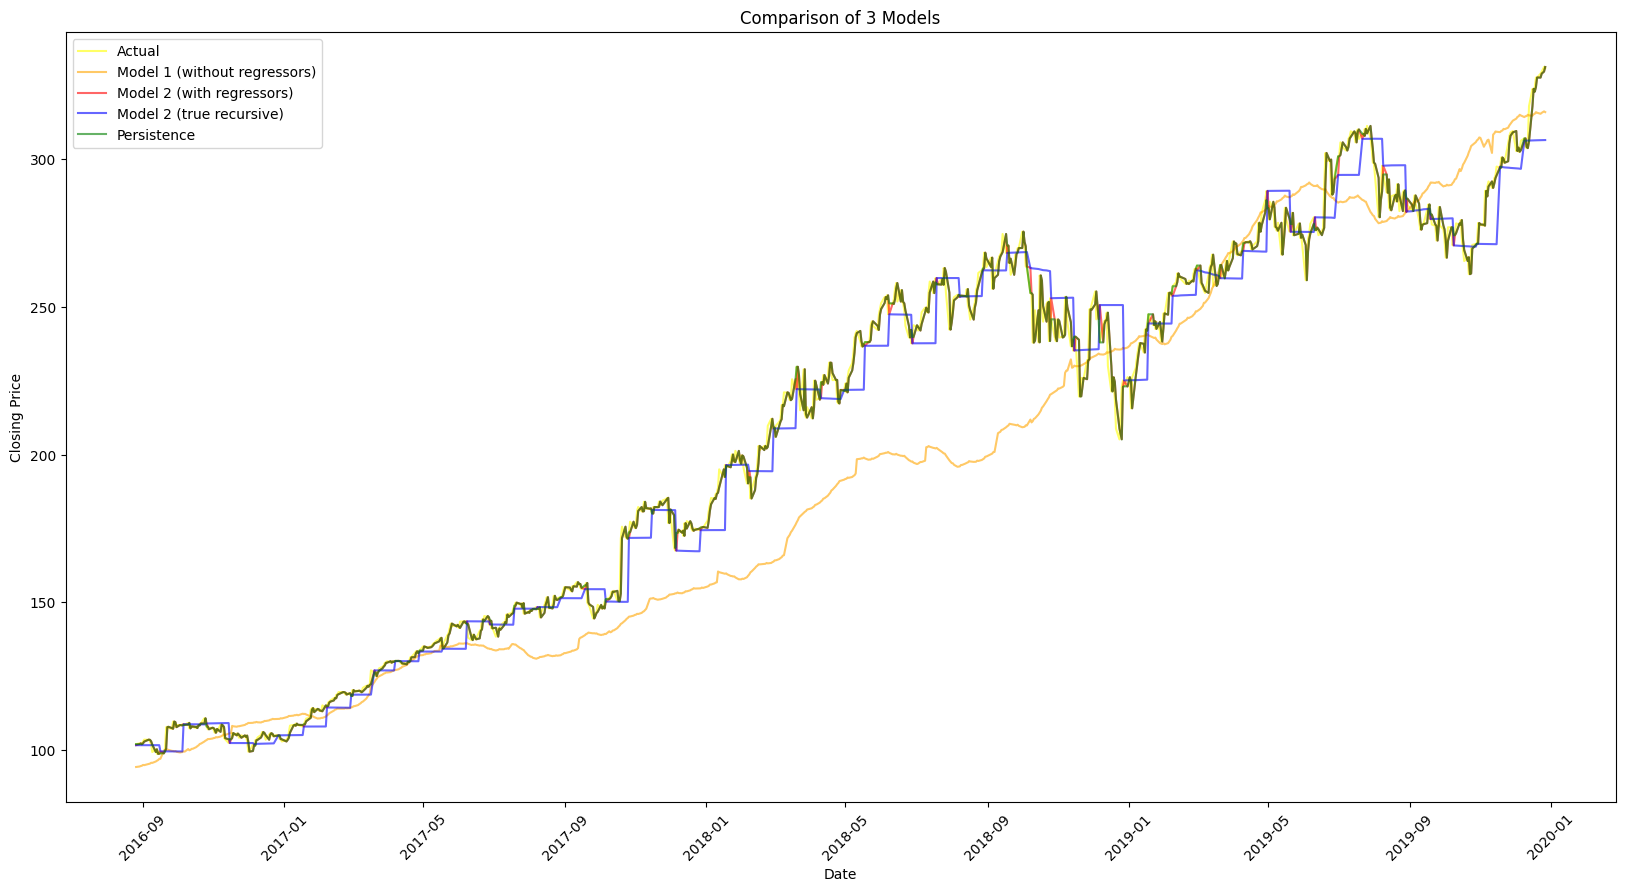

In [40]:
# visualize all 3 models' predictions side by side
plt.figure(figsize=(20, 10))
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_actual'], label='Actual', color = 'yellow', alpha = 0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_no_reg'], label='Model 1 (without regressors)', color = 'orange', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_with_reg_nr'], label='Model 2 (with regressors)', color = 'red', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_with_reg'], label='Model 2 (true recursive)', color = 'blue', alpha=0.6)
plt.plot(comparison_all_models_complete['ds'], comparison_all_models_complete['y_pred_persistence'], label='Persistence', color = 'green', alpha=0.6)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Comparison of 3 Models')
plt.legend()
plt.show()

Here is the direct link to the dataset. The dataset is Adobe stock data from the datacard at this address https://www.kaggle.com/datasets/paultimothymooney/stock-market-data/data.